In [1]:
import sys
sys.path.append("..")

In [2]:
%load_ext cython

In [2]:
# to run on mercer to convert cyril's files

import numpy as np
import re
import pickle

number = r"[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?"
vector = r"\[(%s),(%s),(%s),(%s)\]" % (number, number, number, number)

def dat2arrays(filename, out):  
    n = 0
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("HADS: "):
                e = []
                
                for p in re.findall(vector, line):
                    e.append([float(p[0]), float(p[1]), float(p[2]), float(p[3])])
                    
                e = np.array(e)
                
                pickle.dump(e, out, protocol=2)
                
                n += 1
                if n % 1000 == 0:
                    print n

In [3]:
%%cython -f -+ -I/usr/local/include --link-args=-Wl,-rpath,/usr/local/lib -lm -L/usr/local/lib -lfastjettools -lfastjet -lfastjetplugins -lsiscone_spherical -lsiscone
import numpy as np
cimport numpy as np
np.import_array()

from libcpp.pair cimport pair
from libcpp.vector cimport vector

cdef extern from "/home/gilles/gdrive/research/sandbox/learning-qcd-rnn/notebooks/fj.cc":
    void fj(vector[double]& a, 
            vector[vector[int]]& trees, 
            vector[vector[double]]& contents, 
            vector[double]& masses, 
            vector[double]& pts, 
            double R, int jet_algorithm)
    
cpdef cluster(np.ndarray[np.double_t, ndim=2, mode="c"] a, 
              R=1.0, jet_algorithm=0):
    cdef vector[double] v
    cdef vector[vector[int]] trees
    cdef vector[vector[double]] contents
    cdef vector[double] masses
    cdef vector[double] pts 
    for value in a.ravel():
        v.push_back(value)
    
    fj(v, trees, contents, masses, pts, R=R, jet_algorithm=jet_algorithm)
    jets = []
    
    for tree, content, mass, pt in zip(trees, contents, masses, pts):
        tree = np.array([e for e in tree]).reshape(-1, 2)
        content = np.array([e for e in content]).reshape(-1, 4)
        jets.append((tree, content, mass, pt))
        
    return jets

In [4]:
import copy
from rootpy.vector import LorentzVector
from recnn.preprocessing import _pt

def preprocess(jet, output="kt", trimming=0.0):
    jet = copy.deepcopy(jet)
    constituents = jet["content"][jet["tree"][:, 0] == -1] 

    # run kt (R=0.3) on the constituents c of j, resulting in subjets sj1, sj2, ..., sjN
    subjets = cluster(constituents, R=0.3, jet_algorithm=0)
    
    # trimming
    if trimming > 0.0:
        subjets = [(tree, content, mass, pt) for tree, content, mass, pt in subjets if pt > trimming * jet["pt"]]
    else:
        subjets = [(tree, content, mass, pt) for tree, content, mass, pt in subjets]
    
    # phi = sj1.phi()
    # for all c, do c.rotate_z(-phi)
    v = subjets[0][1][0]
    v = LorentzVector(v)
    phi = v.phi()
    
    for _, content, _, _ in subjets:
        for i in range(len(content)):
            v = LorentzVector(content[i])
            v.rotate_z(-phi)
            content[i, 0] = v[0]
            content[i, 1] = v[1]
            content[i, 2] = v[2]
            content[i, 3] = v[3]
            
    # bv = sj1.boost_vector()
    # bv.set_perp(0)
    # for all c, do c.boost(-bv)
    v = subjets[0][1][0]
    v = LorentzVector(v)
    bv = v.boost_vector()
    bv.set_perp(0)
    
    for _, content, _, _ in subjets:        
        for i in range(len(content)):
            v = LorentzVector(content[i])
            v.boost(-bv)
            content[i, 0] = v[0]
            content[i, 1] = v[1]
            content[i, 2] = v[2]
            content[i, 3] = v[3]
    
    # deltaz = sj1.pz - sj2.pz
    # deltay = sj1.py - sj2.py
    # alpha = -atan2(deltaz, deltay)
    # for all c, do c.rotate_x(alpha)
    if len(subjets) >= 2:
        deltaz = subjets[0][1][0, 2] - subjets[1][1][0, 2]
        deltay = subjets[0][1][0, 1] - subjets[1][1][0, 1]
        alpha = -np.arctan2(deltaz, deltay)

        for _, content, _, _ in subjets:
            for i in range(len(content)):
                v = LorentzVector(content[i])
                v.rotate_x(alpha)
                content[i, 0] = v[0]
                content[i, 1] = v[1]
                content[i, 2] = v[2]
                content[i, 3] = v[3]
    
    # if sj3.pz < 0: for all c, do c.set_pz(-c.pz)
    if len(subjets) >= 3 and subjets[2][1][0, 2] < 0:
        for _, content, _, _ in subjets:
            for i in range(len(content)):
                content[i, 2] *= -1.0
                
    # finally recluster all transformed constituents c into a single jet 
    constituents = []
    
    for tree, content, _, _ in subjets:
        constituents.append(content[tree[:, 0] == -1])
        
    constituents = np.vstack(constituents)
    
    if output == "anti-kt":
        subjets = cluster(constituents, R=200., jet_algorithm=1)
    elif output == "kt":
        subjets = cluster(constituents, R=200., jet_algorithm=0)
    elif output == "cambridge":
        subjets = cluster(constituents, R=200., jet_algorithm=2)
    else:
        raise
    
    jet["tree"] = subjets[0][0]
    jet["content"] = subjets[0][1]
    
    v = LorentzVector(jet["content"][0])
    jet["phi"] = v.phi()
    jet["eta"] = v.eta()
    jet["energy"] = v.E()
    jet["mass"] = v.m()
    jet["pt"] = v.pt()
    jet["root_id"] = 0
    
    return jet

In [5]:
def cast(event):
    a = np.zeros((len(event), 4))
    
    for i, p in enumerate(event):
        v = LorentzVector()
        v.set_pt_eta_phi_e(p[0], p[1], p[2], p[3])
        a[i, 0] = v.px
        a[i, 1] = v.py
        a[i, 2] = v.pz
        a[i, 3] = v.e
        
    return a

In [ ]:
# events with structured jets
bkg = open("../data/events/dijet-particles.dat", "rb")
signal = open("../data/events/wprime-particles.dat", "rb")

train = open("../data/events/antikt-kt-train.pickle", "wb")
test = open("../data/events/antikt-kt-test.pickle", "wb")

source = bkg
dest = train

n_train = 0
n_train_max = 100000
n_test = 0
n_test_max = 100000

trials = 600000  # max = 300000 + 300000

for i in range(trials):
    if i % 500 == 0:
        print(i, n_train, n_test)
    
    e = pickle.load(source)
    e = cast(e)  
    discard = False
    jets = []
    
    for j, (tree, content, mass, pt) in enumerate(cluster(e, jet_algorithm=1)): # antikt    
        if j == 0 and not (240 <= pt <= 360):  
            discard = True
            break
            
        jet = {}
        jet["root_id"] = 0
        jet["tree"] = tree
        jet["content"] = content
        jet["mass"] = mass
        jet["pt"] = pt
        jet["energy"] = content[0, 3]

        px = content[0, 0]
        py = content[0, 1]
        pz = content[0, 2]
        p = (content[0, 0:3] ** 2).sum() ** 0.5
        eta = 0.5 * (np.log(p + pz) - np.log(p - pz))
        phi = np.arctan2(py, px)

        jet["eta"] = eta
        jet["phi"] = phi
        
        try:
            jets.append((phi, eta, pt, mass, preprocess(jet, output="kt")))
            # jets.append((phi, eta, pt, mass, sequentialize_by_pt(preprocess(jet, output="anti-kt"), reverse=True))) 
        except IndexError:
            if j < 10:
                discard = True

    if not discard:
        pickle.dump((jets, 0 if source == bkg else 1), 
                    dest, 
                    protocol=2)
                    
        if source == bkg:
            source = signal
        else:
            source = bkg
            
        if dest == train:
            n_train += 1
            
        if dest == test:
            n_test += 1
            
        if n_train >= n_train_max:
            dest = test
            
        if n_test >= n_test_max:
            break
                    
bkg.close()
signal.close()
train.close()
test.close()

In [ ]:
# jet 4 momenta
fd = open("../data/events/antikt-kt-test.pickle", "rb")
out = open("../data/events/jet4v-test.pickle", "wb")

i = 0

while True:
    if i % 500 == 0:
        print i
    
    try:
        e, y = pickle.load(fd)
        vs = []
        
        for phi, eta, pt, mass, _ in e:
            vs.append((phi, eta, pt, mass))
            
        pickle.dump((np.array(vs), y), out, protocol=2)
        
        i += 1

    except EOFError:
        break
        
fd.close()
out.close()

In [ ]:
# all original 4 momenta
def cast2(event):
    a = np.zeros((len(event), 4))
    
    for i, p in enumerate(event):
        v = LorentzVector()
        v.set_pt_eta_phi_e(p[0], p[1], p[2], p[3])
        a[i, 0] = v.pt()
        a[i, 1] = v.eta()
        a[i, 2] = v.phi()
        a[i, 3] = v.m()
        
    # sort by desc-pT
    indices = np.argsort(a[:, 0])[::-1]
    a = a[indices]
        
    return a

bkg = open("../data/events/dijet-particles.dat", "rb")
signal = open("../data/events/wprime-particles.dat", "rb")

train = open("../data/events/all4v-train.pickle", "wb")
test = open("../data/events/all4v-test.pickle", "wb")

source = bkg
dest = train

n_train = 0
n_train_max = 100000
n_test = 0
n_test_max = 100000

trials = 600000  # max = 300000 + 300000

for i in range(trials):
    if i % 500 == 0:
        print(i, n_train, n_test)
    
    e = pickle.load(source)
    discard = False
    
    tree, content, mass, pt = cluster(cast(e), jet_algorithm=1)[0]
    if not (240 <= pt <= 360):  
        discard = True

    if not discard:
        pickle.dump((cast2(e), 0 if source == bkg else 1), 
                    dest, 
                    protocol=2)
                    
        if source == bkg:
            source = signal
        else:
            source = bkg
            
        if dest == train:
            n_train += 1
            
        if dest == test:
            n_test += 1
            
        if n_train >= n_train_max:
            dest = test
            
        if n_test >= n_test_max:
            break
                    
bkg.close()
signal.close()
train.close()
test.close()

# Checks

In [27]:
data = open("../data/events/antikt-kt-train.pickle", "rb")

mass0 = []
mass1 = []
mass2 = []
mass3 = []

for i in range(10000):
    event, y = pickle.load(data)
    
    if y == 0:
        mass0.append(event[0][3])
        mass1.append(event[1][3])
        mass2.append(event[2][3])
        mass3.append(event[3][3])
    
data.close()

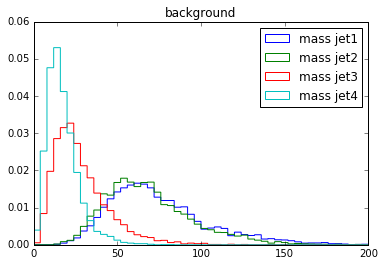

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(mass0, histtype="step", bins=50, range=(0, 200), label="mass jet1", normed=1)
plt.hist(mass1, histtype="step", bins=50, range=(0, 200), label="mass jet2", normed=1)
plt.hist(mass2, histtype="step", bins=50, range=(0, 200), label="mass jet3", normed=1)
plt.hist(mass3, histtype="step", bins=50, range=(0, 200), label="mass jet4", normed=1)
plt.legend()
plt.title("background")
plt.show()